# Fitting Univariate Distributions

*Purpose*: 


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

For this exercise, we'll study a dataset of observations on die cast aluminum parts.


In [2]:
from grama.data import df_shewhart


# The steps to fitting

1. Check for *statistical control*
2. Select candidate distributions
3. Fit and assess


# Check for *statistical control*



### __qX__ Make a histogram of the `tensile_strength`


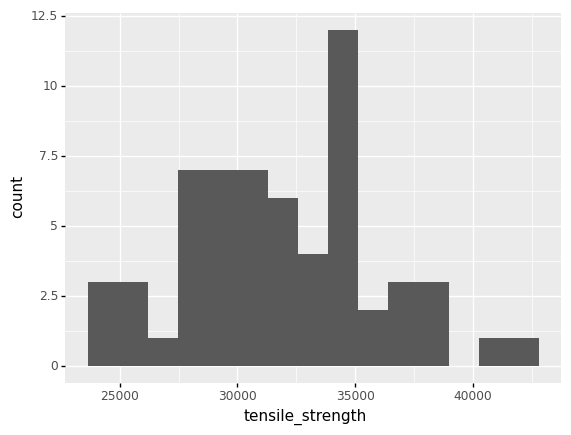

<ggplot: (8786499661692)>

In [15]:
## TASK:
(
    df_shewhart
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_histogram(bins=15)
)
# solution-end

*Observations*



*Note*: To help with the next task, it will be helpful to know about the *integer division* operator `//`. This divides by a desired value, but rounds down to the nearest integer.


In [3]:
print("1 // 4 = {}".format(1 // 4))
print("2 // 4 = {}".format(2 // 4))
print("3 // 4 = {}".format(3 // 4))
print("4 // 4 = {}".format(4 // 4))
print("5 // 4 = {}".format(5 // 4))

1 // 4 = 0
2 // 4 = 0
3 // 4 = 0
4 // 4 = 1
5 // 4 = 1


## Control charts

TODO

- By taking *batch means*, we can use the central limit theorem to make quantitative, statistical statements about the observations.
- By taking *small* batches, we can attribute strange patterns to a small number of observations. This gives us somewhere to look if we detect strange behavior.

The following is an example of a control chart: The points are batch means, the solid horizontal line is the mean of all observations, and the dashed lines are the *control limits* (discussed below). With this chart, we can look for various kinds of patterns:


![Example control chart demonstrating two kinds of patters: a batch mean that exceeds the control limits, and a "run" of batch means that lies to one side of the grand mean.](images/control-chart.png)


Some patterns illustrated above:

- Outliers: The control limits (dashed lines) are constructed such that about one batch mean in a thousand should lie outside the limits. Batch means that exceed the limits are therefore suspicious, and worth investigating further.
- Off-center runs: Batch means should be distributed roughly equally above and below the grand mean (solid line). A sequence (a "run") of batch means that lie all above (or all below) the grand mean are therefore suspicious, and worth investigating further.


If you detect suspicious patterns using a control chart, then there is evidence that the process being studied is *not* under statistical control. The batches associated with suspicious behavior should then be investigated in further detail, in order to hunt down and eliminate any assignable cause(s) of variability.

If you *do not* detect suspicious patterns, then you can *provisionally* state that the process is under statistical control. A quantity under statistical control can be treated as random, which will endorse modeling that quantity with a distribution.


### __qX__ Add a group identifier

Create a group identifier column `id_group` that assigns observations to consecutive groups of four. Make sure the first group identifier is `0`, and use sequential integers.


In [4]:
## TODO: Create a group identifier column to make
# batches of 4 consecutive values
n_grp = 4

df_rolling = (
    df_shewhart

    >> gr.tf_mutate(id_group=DF.index // n_grp)
)

## NOTE: Don't edit the following; use this to check your work
assert \
    "id_group" in df_rolling.columns, \
    "df_rolling missing the id_group column"

assert \
    all(df_rolling.id_group[:8] == [0]*4 + [1]*4), \
    "The id_group column is incorrect; " + \
    "the first 8 values should be 0, 0, 0, 0, 1, 1, 1, 1"


### __qX__ Compute the batch means

Compute the mean within each consecutive "batch" of observations.


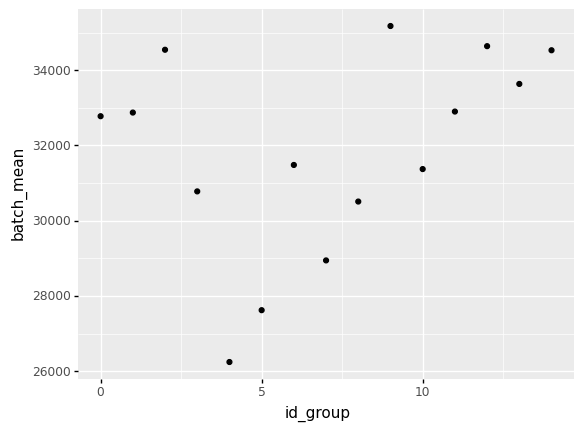

<ggplot: (8786500782388)>

In [5]:
## TASK: Compute the `batch_mean` within 
# each group of observations
df_batches = (
    df_rolling

    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(
        batch_mean=gr.mean(DF.tensile_strength)
    )
)

## NOTE: Don't edit the following; use this to check your work
assert \
    df_batches.shape[0] == (df_shewhart.shape[0] / n_grp), \
    "Size of df_batches is incorrect; " + \
    "make sure you grouped properly."

(
    df_batches
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_point()
)

## Control limits

Remember from the Monte Carlo exercise that a confidence interval for the mean can be approximated using the central limit theorem via

$$[\hat{\mu} - q \hat{\sigma} / \sqrt{n}, \hat{\mu} + q \hat{\sigma} / \sqrt{n}],$$

where $\hat{\mu}$ is the sample mean, $\hat{\sigma}$ is the sample standard deviation, and $n$ is the number of samples used to compute $\hat{\mu}$.


In [6]:
# NOTE: No need to edit; this computes the probability of
# finding a batch mean outside the control limits
mg_norm = gr.marg_mom("norm", mean=0, sd=1)
mg_norm.p(-3) * 2


0.0026997960632601866

In [7]:
# NOTE: No need to edit
df_stats = (
    df_shewhart
    >> gr.tf_summarize(
        tys_mean=gr.mean(DF.tensile_strength),
        tys_sd=gr.sd(DF.tensile_strength),
        n=gr.n(DF.tensile_strength),
    )
)
df_stats


,tys_mean,tys_sd,n
0,31869.366667,3996.380795,60


### __qX__ Compute the control limits

Compute the control limits for the batch means. Use a multiplier of $q = 3$. Answer the questions under *observations* below.


0    37863.937859
Name: tys_hi, dtype: float64


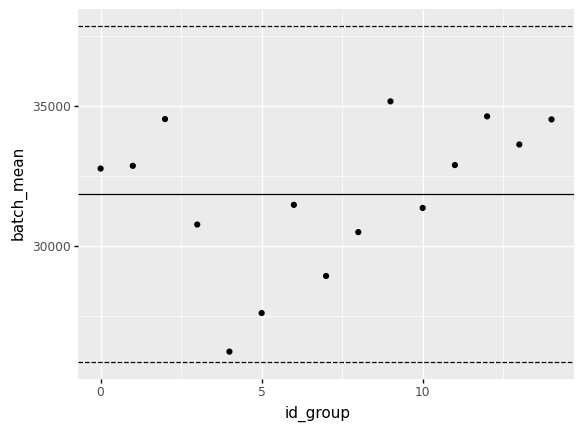

<ggplot: (8786500490671)>

In [8]:
df_limits = (
    df_stats
    >> gr.tf_mutate(
        tys_lo=DF.tys_mean - 3 * DF.tys_sd / gr.sqrt(n_grp),
        tys_hi=DF.tys_mean + 3 * DF.tys_sd / gr.sqrt(n_grp),
    )
)

## NOTE: Don't edit the following; use this to check your work
print(df_limits.tys_hi)
assert \
    all(abs(df_limits.tys_lo - 25874.795475) < 1e-2), \
    "Lower control limit is incorrect; " + \
    "did you use the same sample size used to compute " + \
    "the batch means?"
assert \
    all(abs(df_limits.tys_hi - 37863.937859) < 1e-2), \
    "Upper control limit is incorrect; " + \
    "did you use the same sample size used to compute " + \
    "the batch means?"

(
    df_batches
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_lo"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_hi"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_limits,
        mapping=gr.aes(yintercept="tys_mean"),
    )
    + gr.geom_point()
)

*Observations*



## Vary the batch size

As with adjusting the bin size of a histogram, it is also important to test different batch sizes with a control chart. The following re-constructs the control chart, but with a slightly smaller batch size:


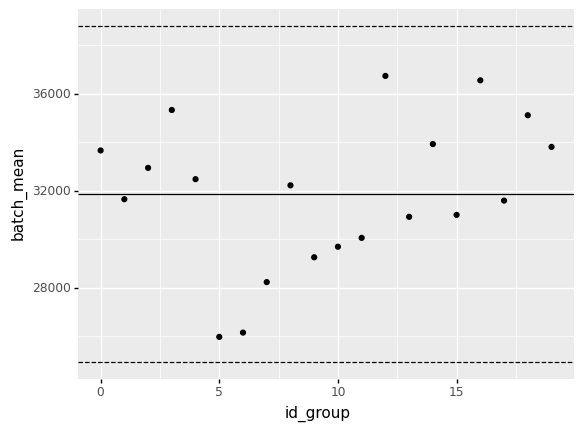

<ggplot: (8786500294575)>

In [9]:
# NOTE: No need to edit this
n_temp = 3

(
    df_shewhart
    >> gr.tf_mutate(id_group=DF.index // n_temp)
    >> gr.tf_group_by(DF.id_group)
    >> gr.tf_summarize(batch_mean=gr.mean(DF.tensile_strength))
    
    >> gr.ggplot(gr.aes("id_group", "batch_mean"))
    + gr.geom_hline(
        df_stats
        >> gr.tf_mutate(
            y=DF.tys_mean - 3 * DF.tys_sd / gr.sqrt(n_temp)
        ),
        gr.aes(yintercept="y"),
        linetype="dashed",
    )
    + gr.geom_hline(
        df_stats
        >> gr.tf_mutate(
            y=DF.tys_mean + 3 * DF.tys_sd / gr.sqrt(n_temp)
        ),
        gr.aes(yintercept="y"),
        linetype="dashed",
    )
    + gr.geom_hline(
        data=df_stats,
        mapping=gr.aes(yintercept="tys_mean"),
    )
    + gr.geom_point()
)

Here we see reasonably similar behavior with no violations of the control limits and no suspicious patterns. The data from this process appear to be under statistical control. Thus, we can proceed with modeling the `tensile_strengh` as a random quantity.


# Select candidate distributions


## (Short) list of distributions

| Distribution | Name | Description |
|---|---|---|
| Normal (Gaussian) | `"norm"` | Symmetric; infinite extent |
| Lognormal | `"lognormal"` | Asymmetric; positive |
| Uniform | `"uniform"` | Bounded, flat |
| Beta | `"beta"` | Bounded, flexible shape |
| Weibull | `"weibull_min"` | Asymmetric; positive |


### __qX__ Select reasonable distributions


# Fit and assess


## QQ plots


### __qX__ Inspect this QQ plot

TODO


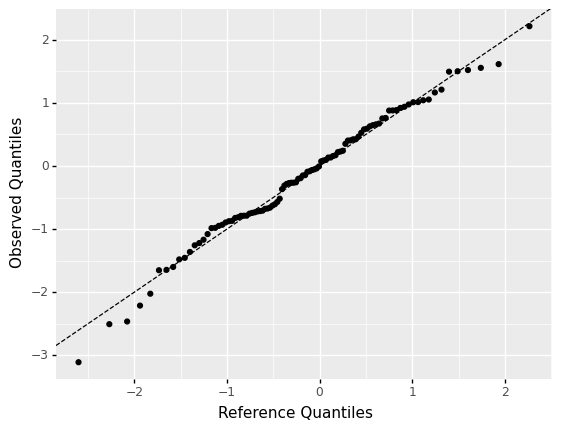

<ggplot: (8786500813403)>

In [10]:
## NOTE: No need to edit; run and inspect
# Define a standard normal distribution
mg_norm = gr.marg_mom("norm", mean=0, sd=1)

(
    # Draw some random values
    gr.df_make(z=mg_norm.r(100))
    # Compute theoretical quantiles based on fitted normal
    >> gr.tf_mutate(q=gr.qqvals(DF.z, "norm"))
    
    # Visualize
    >> gr.ggplot(gr.aes("q", "z"))
    # Add a guideline
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

*Observations*



### __qX__ Fit a distribution for the `tensile_strength`

TODO


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


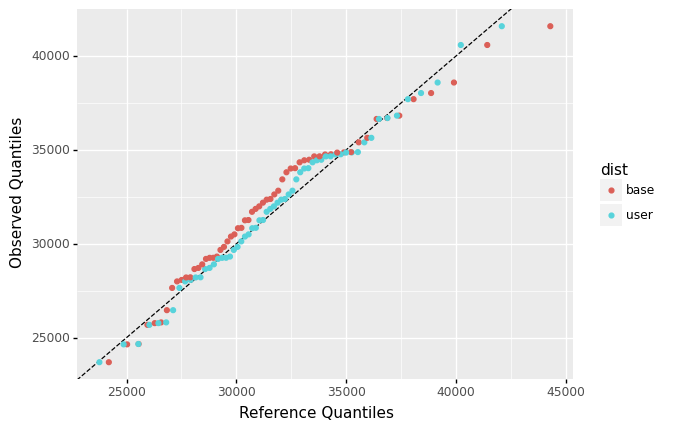

<ggplot: (8786500068452)>

In [11]:
# TASK: Fit a distribution for the tensile_strength;
# assign it to mg_user below

mg_user = gr.marg_fit(
    "lognorm", 
    df_shewhart.tensile_strength,
    floc=0,
)
# NOTE: Don't edit this; use to check your results
mg_base = gr.marg_fit(
    "gengamma",
    df_shewhart.tensile_strength,
    floc=0,
)

(
    df_shewhart
    >> gr.tf_mutate(
        q_base=gr.qqvals(DF.tensile_strength, marg=mg_base),
        q_user=gr.qqvals(DF.tensile_strength, marg=mg_user),
    )
    >> gr.tf_pivot_longer(
        columns=["q_base", "q_user"],
        names_to=[".value", "dist"],
        names_sep="_",
    )
    
    >> gr.ggplot(gr.aes("q", "tensile_strength", color="dist"))
    + gr.geom_abline(intercept=0, slope=1, linetype="dashed")
    + gr.geom_point()
    + gr.labs(x="Reference Quantiles", y="Observed Quantiles")
)

*Observations*

- What distribution did you choose to fit?
  - I fit a lognormal `"lognorm"` distribution.
- How does your distribution (`user`) compare with the generalized gamma distribution (`base`)?
  - The lognormal fits a fair bit better than the generalized gamma; both the middle of the distribution and the right tail lie closer to the identity line.
<!-- solution-end -->

# Use the model

TODO

$$g_{\text{tension}} = S - F/A$$


In [12]:
## NOTE: No need to edit
md_structure = (
    gr.Model("Uniaxial tension member")
    >> gr.cp_vec_function(
        fun=lambda df: gr.df_make(
            g_tension=df.S - df.F / df.A,
        ),
        var=["S", "F", "A"],
        out=["g_tension"],
    )
    >> gr.cp_bounds(A=(1.0, 5.0))
    >> gr.cp_marginals(
        S=mg_user,
        F=gr.marg_mom("lognorm", mean=8e4, cov=0.1, floc=0),
    )
    >> gr.cp_copula_independence()
)
md_structure

model: Uniaxial tension member

  inputs:
    var_det:
      A: [1.0, 5.0]

    var_rand:
      S: (+0) lognorm, {'mean': '3.187e+04', 's.d.': '4.019e+03', 'COV': 0.13, 'skew.': 0.38, 'kurt.': 3.26}
      F: (+0) lognorm, {'mean': '8.000e+04', 's.d.': '8.000e+03', 'COV': 0.1, 'skew.': 0.3, 'kurt.': 3.16}

    copula:
      Independence copula

  functions:
      f0: ['S', 'F', 'A'] -> ['g_tension']

In [13]:
(
    md_structure
    >> gr.ev_sample(n=1e3, df_det=gr.df_make(A=[2, 3, 4]))
    >> gr.tf_group_by(DF.A)
    >> gr.tf_summarize(
        pof_lo=gr.binomial_ci(DF.g_tension <= 0, alpha=0.95, side="lo"),
        pof_mu=gr.mean(DF.g_tension <= 0),
        pof_up=gr.binomial_ci(DF.g_tension <= 0, alpha=0.95, side="up"),
    )
)

eval_sample() is rounding n...


,A,pof_lo,pof_mu,pof_up
0,2,0.920463,0.921,0.921533
1,3,0.131330,0.132,0.132673
2,4,0.001913,0.002,0.002091
